In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '5 days LSTM Time Series Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [8]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-02-12   725.299988  680.857339  -5.533611  42959323.0     2.0
2019-02-13   717.919983  686.559284 -15.712368  39450180.0     2.0
2019-02-14   735.250000  694.050163  -1.218823  43017886.0     2.0
2019-02-15   737.159973  700.682442  -8.071529  46243699.0     2.0
2019-02-18   724.780029  704.389763 -23.444619  43919901.0     2.0


In [9]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14      OBV_7  labels
Date                                                              
2020-02-13  1097.270020  1076.474651 -15.554098  4904879.0     2.0
2020-02-14  1091.000000  1078.709320 -17.096133  1869143.0     2.0
2020-02-17  1088.000000  1080.138656 -19.336778  -459617.0     2.0
2020-02-18  1093.819946  1082.243470 -14.989967  2243205.0     2.0
2020-02-19  1084.000000  1082.513705 -22.324305  -423291.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


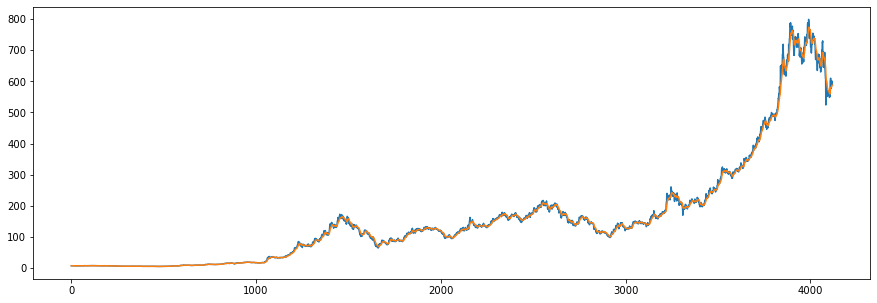

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 5, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 3747, 0.0: 186, 1.0: 183})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.364653243847875, 1: 7.5159817351598175, 2: 0.36614392169947724}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 33ms/step - loss: 0.2806 - accuracy: 0.4727 - mse: 0.4361 - weighted_accuracy: 0.3864 - weighted_mse: 0.4710 - val_loss: 0.3014 - val_accuracy: 0.0449 - val_mse: 0.3443 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3443
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.3202 - mse: 0.7066 - weighted_accuracy: 0.5240 - weighted_mse: 0.6634 - val_loss: 0.2940 - val_accuracy: 0.0449 - val_mse: 0.3617 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3617
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1824 - accuracy: 0.2849 - mse: 0.9520 - weighted_accuracy: 0.5648 - weighted_mse: 0.8928 - val_loss: 0.2833 - val_accuracy: 0.0449 - val_mse: 0.3834 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3834
Epoch 4/20
26/26 [==============================] - 0s 

7/7 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.7500 - mse: 1.0378 - weighted_accuracy: 0.7500 - weighted_mse: 1.0378
Test loss: 0.16461104154586792
Test accuracy: 0.75


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 27
actual holds but predicted sell: 11
actual predicted holds: 151
Percentage buys correct: 15.151515151515152%
Percentage sells correct: 0.0%
Percentage holds correct: 92.07317073170732%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 85.88957055214723%


Capital: 100
Share price: $0.11351808346621216
Shares owned at the moment: 878
Cash capital at the moment: $0.05703330413655294


Price increase from previously 

Epoch 18/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1260 - accuracy: 0.4954 - mse: 1.7905 - weighted_accuracy: 0.7531 - weighted_mse: 1.7589 - val_loss: 0.1756 - val_accuracy: 0.4478 - val_mse: 1.7810 - val_weighted_accuracy: 0.4478 - val_weighted_mse: 1.7810
Epoch 19/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1251 - accuracy: 0.4730 - mse: 1.8103 - weighted_accuracy: 0.7472 - weighted_mse: 1.7729 - val_loss: 0.1728 - val_accuracy: 0.4733 - val_mse: 1.8018 - val_weighted_accuracy: 0.4733 - val_weighted_mse: 1.8018
Epoch 20/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1246 - accuracy: 0.4982 - mse: 1.8289 - weighted_accuracy: 0.7476 - weighted_mse: 1.8006 - val_loss: 0.1714 - val_accuracy: 0.4891 - val_mse: 1.8644 - val_weighted_accuracy: 0.4891 - val_weighted_mse: 1.8644
Validation loss: 0.17143534123897552
Validation accuracy: 0.4890776574611664


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

Epoch 1/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1239 - accuracy: 0.4678 - mse: 1.8599 - weighted_accuracy: 0.7495 - weighted_mse: 1.8198 - val_loss: 0.1836 - val_accuracy: 0.4442 - val_mse: 1.8392 - val_weighted_accuracy: 0.4442 - val_weighted_mse: 1.8392
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1221 - accuracy: 0.4985 - mse: 1.8482 - weighted_accuracy: 0.7543 - weighted_mse: 1.8277 - val_loss: 0.1770 - val_accuracy: 0.4769 - val_mse: 1.8617 - val_weighted_accuracy: 0.4769 - val_weighted_mse: 1.8617
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1203 - accuracy: 0.4991 - mse: 1.8766 - weighted_accuracy: 0.7609 - weighted_mse: 1.8544 - val_loss: 0.1829 - val_accuracy: 0.4345 - val_mse: 1.9059 - val_weighted_accuracy: 0.4345 - val_weighted_mse: 1.9059
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.5191 - mse: 1.8652 - weighted_accuracy: 0.7574 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.5577 - mse: 2.3731 - weighted_accuracy: 0.5577 - weighted_mse: 2.3731
Test loss: 0.166995108127594
Test accuracy: 0.557692289352417


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 26
actual holds but predicted sell: 59
actual predicted holds: 104
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 94.54545454545455%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.666666666666664%
Percentage high sells correct: 57.35294117647059%
Percentage mid holds correct: 88.07339449541284%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pri

Epoch 13/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0993 - accuracy: 0.6109 - mse: 2.3478 - weighted_accuracy: 0.8212 - weighted_mse: 2.3882 - val_loss: 0.1931 - val_accuracy: 0.4854 - val_mse: 2.5255 - val_weighted_accuracy: 0.4854 - val_weighted_mse: 2.5255
Epoch 14/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0979 - accuracy: 0.6422 - mse: 2.3511 - weighted_accuracy: 0.8283 - weighted_mse: 2.3973 - val_loss: 0.1882 - val_accuracy: 0.4806 - val_mse: 2.4930 - val_weighted_accuracy: 0.4806 - val_weighted_mse: 2.4930
Epoch 15/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0970 - accuracy: 0.6367 - mse: 2.3428 - weighted_accuracy: 0.8391 - weighted_mse: 2.3738 - val_loss: 0.1825 - val_accuracy: 0.5206 - val_mse: 2.4853 - val_weighted_accuracy: 0.5206 - val_weighted_mse: 2.4853
Epoch 16/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0977 - accuracy: 0.6340 - mse: 2.4020 - weighted_accuracy: 0.8319 - weighted




RUNNING EPOCHS 80 - 100



Epoch 1/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0929 - accuracy: 0.6510 - mse: 2.5092 - weighted_accuracy: 0.8423 - weighted_mse: 2.5751 - val_loss: 0.1766 - val_accuracy: 0.5449 - val_mse: 2.5767 - val_weighted_accuracy: 0.5449 - val_weighted_mse: 2.5767
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 0.6829 - mse: 2.5178 - weighted_accuracy: 0.8475 - weighted_mse: 2.5938 - val_loss: 0.1760 - val_accuracy: 0.5510 - val_mse: 2.6667 - val_weighted_accuracy: 0.5510 - val_weighted_mse: 2.6667
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.6701 - mse: 2.5508 - weighted_accuracy: 0.8535 - weighted_mse: 2.6337 - val_loss: 0.1641 - val_accuracy: 0.5898 - val_mse: 2.7236 - val_weighted_accuracy: 0.5898 - val_weighted_mse: 2.7236
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.6896 - mse: 2.5644 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.6394 - mse: 3.2992 - weighted_accuracy: 0.6394 - weighted_mse: 3.2992
Test loss: 0.14756347239017487
Test accuracy: 0.6394230723381042


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 23
actual holds but predicted sell: 42
actual predicted holds: 124
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 10.638297872340425%
Percentage holds correct: 92.53731343283582%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 63.829787234042556%
Percentage mid holds correct: 86.46616541353383%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697




Epoch 13/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.7600 - mse: 3.3802 - weighted_accuracy: 0.9015 - weighted_mse: 3.4882 - val_loss: 0.1868 - val_accuracy: 0.5886 - val_mse: 3.5986 - val_weighted_accuracy: 0.5886 - val_weighted_mse: 3.5986
Epoch 14/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0712 - accuracy: 0.7849 - mse: 3.3947 - weighted_accuracy: 0.9127 - weighted_mse: 3.4879 - val_loss: 0.1806 - val_accuracy: 0.5862 - val_mse: 3.6642 - val_weighted_accuracy: 0.5862 - val_weighted_mse: 3.6642
Epoch 15/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0715 - accuracy: 0.7640 - mse: 3.3902 - weighted_accuracy: 0.9071 - weighted_mse: 3.4736 - val_loss: 0.1802 - val_accuracy: 0.6238 - val_mse: 3.5138 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 3.5138
Epoch 16/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.7707 - mse: 3.4856 - weighted_accuracy: 0.9032 - weighted

Epoch 1/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.7840 - mse: 3.6167 - weighted_accuracy: 0.9145 - weighted_mse: 3.7502 - val_loss: 0.1694 - val_accuracy: 0.6347 - val_mse: 3.8187 - val_weighted_accuracy: 0.6347 - val_weighted_mse: 3.8187
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.8038 - mse: 3.6964 - weighted_accuracy: 0.9175 - weighted_mse: 3.8109 - val_loss: 0.1696 - val_accuracy: 0.6396 - val_mse: 4.0236 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 4.0236
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.7953 - mse: 3.7071 - weighted_accuracy: 0.9186 - weighted_mse: 3.8348 - val_loss: 0.1573 - val_accuracy: 0.6942 - val_mse: 4.0329 - val_weighted_accuracy: 0.6942 - val_weighted_mse: 4.0329
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0672 - accuracy: 0.8004 - mse: 3.7694 - weighted_accuracy: 0.9184 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.7404 - mse: 4.9019 - weighted_accuracy: 0.7404 - weighted_mse: 4.9019
Test loss: 0.12960435450077057
Test accuracy: 0.7403846383094788


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 8
actual holds but predicted sell: 30
actual predicted holds: 151
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.41916167664671%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 87.5%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 84.33734939759036%


Capital: 100
Share price: $0.02378936423929944
Shares owned at the moment: 4192
Cash capital at the moment: $0.000741317906090444


Price increase from previously

Epoch 19/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.8594 - mse: 5.0496 - weighted_accuracy: 0.9421 - weighted_mse: 5.0757 - val_loss: 0.1785 - val_accuracy: 0.7063 - val_mse: 5.5241 - val_weighted_accuracy: 0.7063 - val_weighted_mse: 5.5241
Epoch 20/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.8499 - mse: 5.1685 - weighted_accuracy: 0.9429 - weighted_mse: 5.1254 - val_loss: 0.1566 - val_accuracy: 0.7536 - val_mse: 5.9577 - val_weighted_accuracy: 0.7536 - val_weighted_mse: 5.9577
Validation loss: 0.15660372376441956
Validation accuracy: 0.7536407709121704


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.7585 - mse: 5.9977 - weighted_accuracy: 0.7585 - weighted_mse: 5.9977
Test loss: 0.15401339530944824
Test accuracy: 0.7584540843963623


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold:

26/26 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.8600 - mse: 5.2749 - weighted_accuracy: 0.9466 - weighted_mse: 5.2455 - val_loss: 0.1621 - val_accuracy: 0.7597 - val_mse: 5.5691 - val_weighted_accuracy: 0.7597 - val_weighted_mse: 5.5691
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.8676 - mse: 5.4134 - weighted_accuracy: 0.9472 - weighted_mse: 5.3523 - val_loss: 0.2158 - val_accuracy: 0.6250 - val_mse: 5.4394 - val_weighted_accuracy: 0.6250 - val_weighted_mse: 5.4394
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.8518 - mse: 5.3815 - weighted_accuracy: 0.9308 - weighted_mse: 5.3282 - val_loss: 0.1767 - val_accuracy: 0.7075 - val_mse: 5.5346 - val_weighted_accuracy: 0.7075 - val_weighted_mse: 5.5346
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.8569 - mse: 5.4421 - weighted_accuracy: 0.9327 - weighted_mse: 5.3723 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.7837 - mse: 6.7985 - weighted_accuracy: 0.7837 - weighted_mse: 6.7985
Test loss: 0.13502377271652222
Test accuracy: 0.7836538553237915


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 5
actual holds but predicted sell: 23
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 8.0%
Percentage holds correct: 90.4494382022472%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 100.0%
Percentage high sells correct: 72.0%
Percentage mid holds correct: 84.18079096045197%


Capital: 100
Share price: $0.02378936423929944
Shares owned at the moment: 4192
Cash capital at the moment: $0.000741317906090444


Price increase from previously bought: 911.4518142839655%

7/7 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.8164 - mse: 8.2926 - weighted_accuracy: 0.8164 - weighted_mse: 8.2926
Test loss: 0.17700490355491638
Test accuracy: 0.8164251446723938


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 4
actual holds but predicted sell: 17
actual predicted holds: 164
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 90.60773480662984%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 85.71428571428571%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.05299905957126327
Shares owned at the moment: 1881
Cash capital at the moment: $0.03461806105653409


P

In [17]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.750000,15.151515,0.000000,92.073171,54.545455,54.545455,85.889571,3112.293787,678.794088
1,0.528846,14.285714,10.526316,94.230769,60.714286,60.526316,86.407767,235.124883,678.794088
2,0.557692,13.333333,11.764706,94.545455,56.666667,57.352941,88.073394,223.896543,678.794088
3,0.605769,16.129032,12.500000,94.214876,61.290323,64.285714,88.333333,800.847541,678.794088
4,0.639423,14.814815,10.638298,92.537313,66.666667,63.829787,86.466165,884.939446,678.794088
5,0.697115,18.181818,10.526316,92.567568,77.272727,65.789474,85.714286,951.609265,678.794088
6,0.740385,0.000000,9.090909,90.419162,87.500000,63.636364,84.337349,1437.525878,678.794088
7,0.769231,0.000000,10.344828,90.751445,100.000000,65.517241,84.883721,1136.056533,678.794088
8,0.783654,0.000000,8.000000,90.449438,100.000000,72.000000,84.180791,1136.056533,678.794088
9,0.798077,0.000000,8.695652,90.607735,100.000000,73.913043,84.444444,1075.497920,678.794088


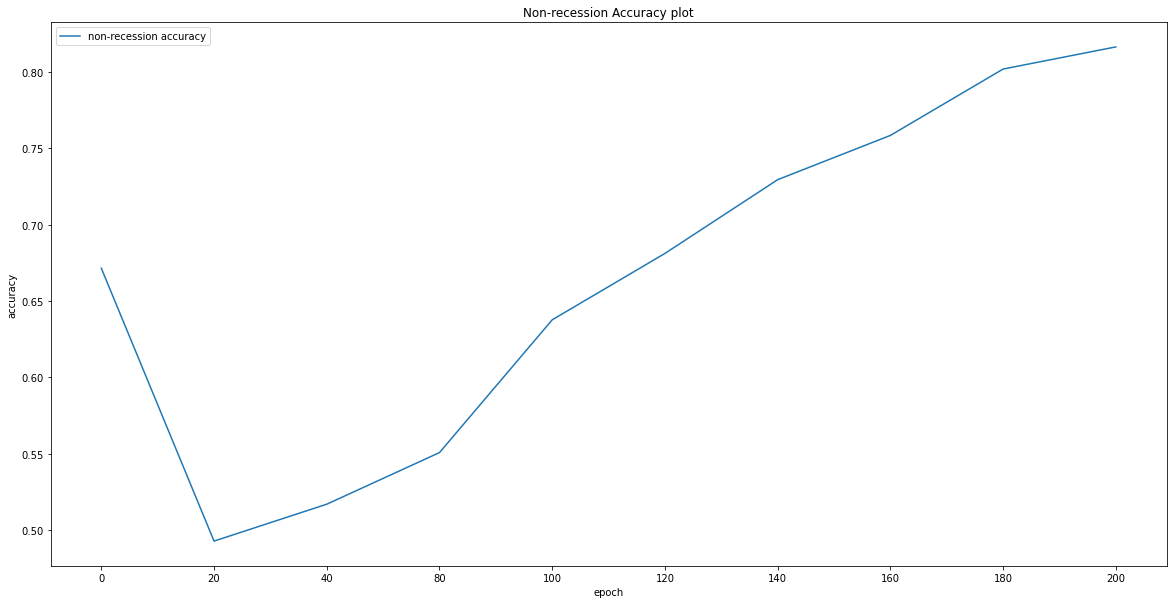

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

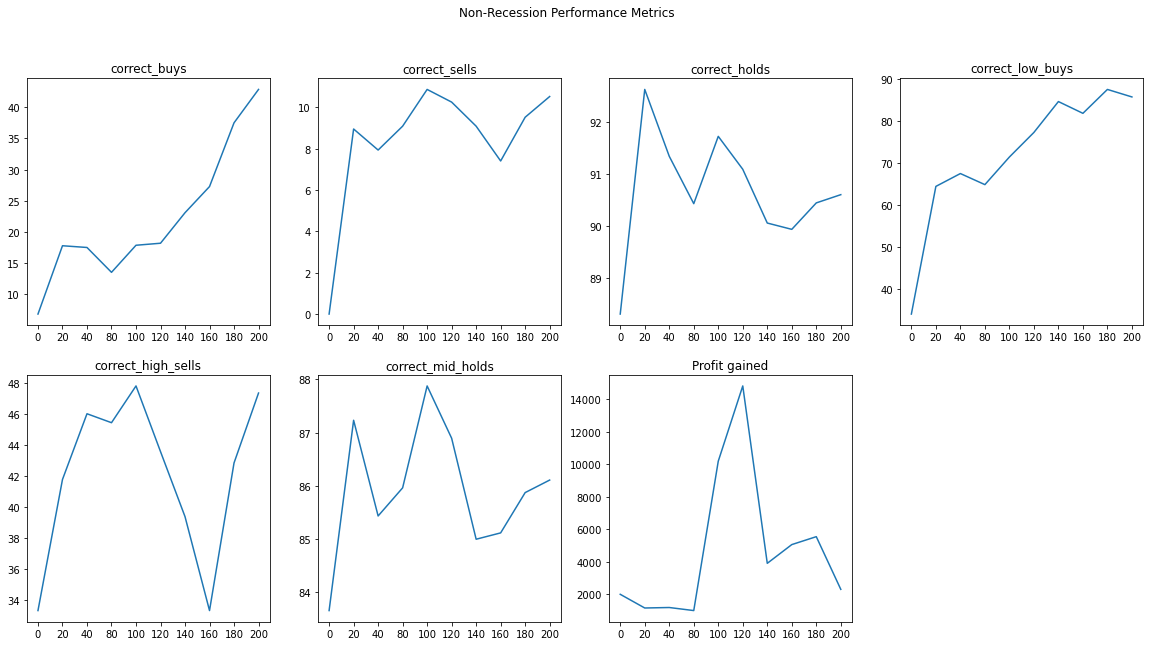

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

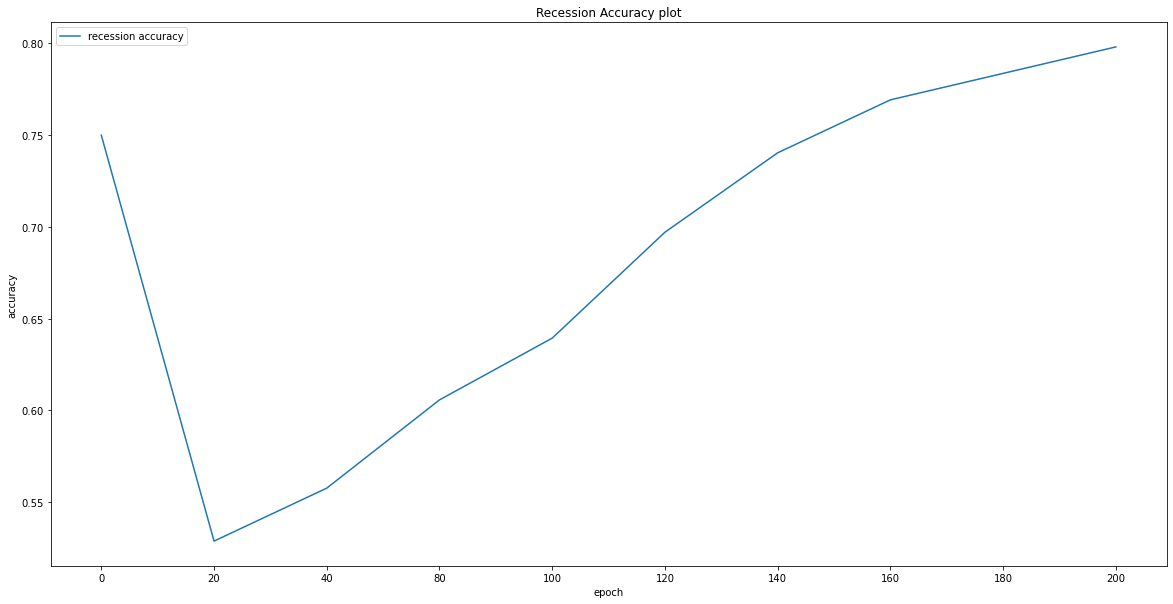

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

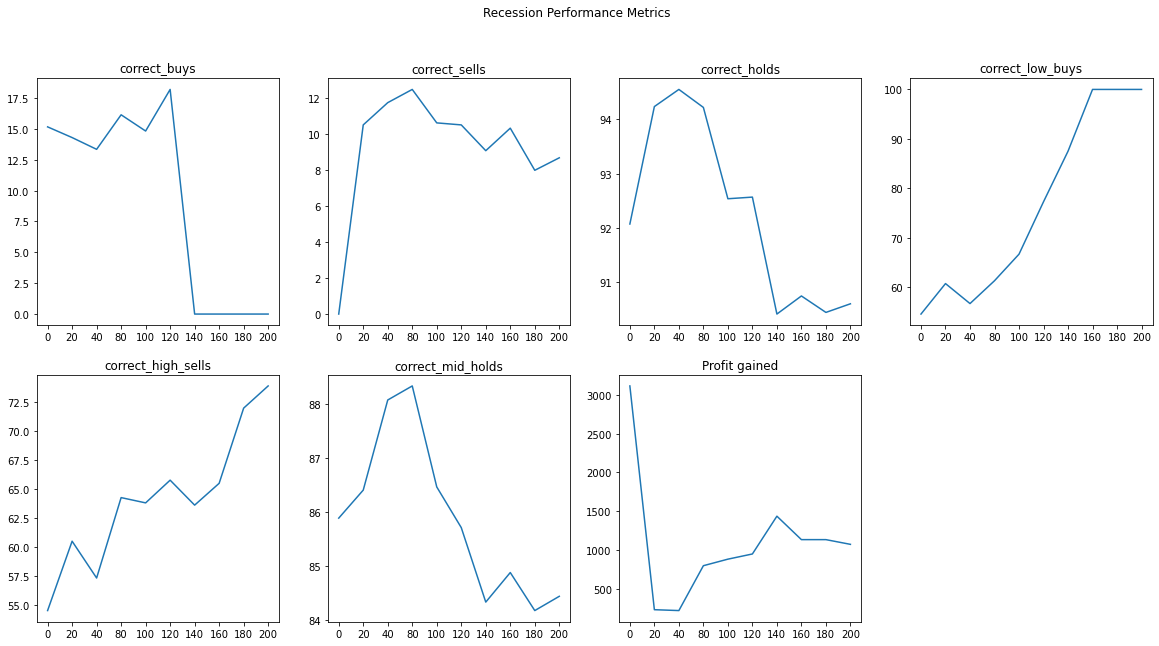

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### midea

In [22]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-02-12    46.080002  42.654367  -4.210488  380829366.0     2.0
2019-02-13    46.490002  43.244464  -6.612900  411118769.0     2.0
2019-02-14    46.799999  43.791470  -6.584998  443533043.0     2.0
2019-02-15    47.150002  44.308167  -2.420572  466454440.0     2.0
2019-02-18    45.270000  44.456141 -30.862341  419918481.0     2.0


In [23]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-13    54.889999  54.718954 -53.549524  20343150.0     2.0
2020-02-14    53.799999  54.577577 -63.102549 -11587509.0     2.0
2020-02-17    53.740002  54.448719 -63.500423 -32591896.0     2.0
2020-02-18    54.400002  54.441224 -52.704009    -86645.0     2.0
2020-02-19    53.529999  54.301035 -52.927131 -33290149.0     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


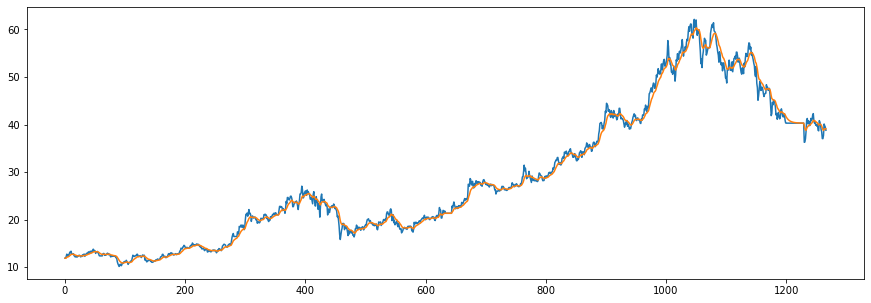

In [24]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 5, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 8.015873015873016, 1: 6.733333333333333, 2: 0.36673928830791575}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 1s 86ms/step - loss: 0.3089 - accuracy: 0.4842 - mse: 0.3696 - weighted_accuracy: 0.2973 - weighted_mse: 0.4382 - val_loss: 0.3046 - val_accuracy: 0.0632 - val_mse: 0.3377 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 0.3377
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.2648 - accuracy: 0.4713 - mse: 0.4335 - weighted_accuracy: 0.4339 - weighted_mse: 0.4700 - val_loss: 0.3033 - val_accuracy: 0.0553 - val_mse: 0.3398 - val_weighted_accuracy: 0.0553 - val_weighted_mse: 0.3398
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.2322 - accuracy: 0.4287 - mse: 0.5065 - weighted_accuracy: 0.4978 - weighted_mse: 0.5131 - val_loss: 0.3016 - val_accuracy: 0.0474 - val_mse: 0.3427 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.3427
Epoch 4/20
8/8 [==============================] - 0s 8ms/step 

8/8 [==============================] - 0s 10ms/step - loss: 0.1388 - accuracy: 0.4297 - mse: 1.3824 - weighted_accuracy: 0.7089 - weighted_mse: 1.3562 - val_loss: 0.2421 - val_accuracy: 0.0672 - val_mse: 0.4772 - val_weighted_accuracy: 0.0672 - val_weighted_mse: 0.4772
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1380 - accuracy: 0.4376 - mse: 1.3927 - weighted_accuracy: 0.7105 - weighted_mse: 1.3881 - val_loss: 0.2389 - val_accuracy: 0.0672 - val_mse: 0.4894 - val_weighted_accuracy: 0.0672 - val_weighted_mse: 0.4894
Epoch 3/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1356 - accuracy: 0.4515 - mse: 1.4172 - weighted_accuracy: 0.7168 - weighted_mse: 1.4019 - val_loss: 0.2352 - val_accuracy: 0.0830 - val_mse: 0.5014 - val_weighted_accuracy: 0.0830 - val_weighted_mse: 0.5014
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.4356 - mse: 1.4339 - weighted_accuracy: 0.7173 - weighted_mse: 1.4053 - val_los

Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.1183 - accuracy: 0.5475 - mse: 1.6232 - weighted_accuracy: 0.7912 - weighted_mse: 1.6103 - val_loss: 0.1803 - val_accuracy: 0.5652 - val_mse: 0.8226 - val_weighted_accuracy: 0.5652 - val_weighted_mse: 0.8226
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.5535 - mse: 1.6385 - weighted_accuracy: 0.7870 - weighted_mse: 1.6506 - val_loss: 0.1783 - val_accuracy: 0.5692 - val_mse: 0.8487 - val_weighted_accuracy: 0.5692 - val_weighted_mse: 0.8487
Epoch 3/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1150 - accuracy: 0.5426 - mse: 1.6610 - weighted_accuracy: 0.7830 - weighted_mse: 1.6631 - val_loss: 0.1754 - val_accuracy: 0.6166 - val_mse: 0.8685 - val_weighted_accuracy: 0.6166 - val_weighted_mse: 0.8685
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.5406 - mse: 1.6670 - weighted_accuracy: 0.7899 - weighted_mse: 1.656

7/7 [==============================] - 0s 3ms/step - loss: 0.1395 - accuracy: 0.8606 - mse: 1.1718 - weighted_accuracy: 0.8606 - weighted_mse: 1.1718
Test loss: 0.13945919275283813
Test accuracy: 0.8605769276618958


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 1
actual predicted holds: 179
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.26804123711341%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 100.0%
Percentage mid holds correct: 84.97409326424871%


Capital: 100
Share price: $0.12293722532129535
Shares owned at the moment: 811
Cash capital at the moment: $0.02372951765664766


Price increase from previously bought: 342.081

7/7 [==============================] - 0s 3ms/step - loss: 0.1400 - accuracy: 0.6971 - mse: 1.5011 - weighted_accuracy: 0.6971 - weighted_mse: 1.5011
Test loss: 0.14001083374023438
Test accuracy: 0.6971153616905212


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 22
actual holds but predicted sell: 30
actual predicted holds: 141
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 6.25%
Percentage holds correct: 92.76315789473684%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 59.375%
Percentage mid holds correct: 84.10596026490066%


Capital: 100
Share price: $0.17708808382110208
Shares owned at the moment: 563
Cash capital at the moment: $0.025232182943511816


Price increase from previou

Epoch 15/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.7683 - mse: 2.4423 - weighted_accuracy: 0.9150 - weighted_mse: 2.4178 - val_loss: 0.1476 - val_accuracy: 0.6285 - val_mse: 2.0551 - val_weighted_accuracy: 0.6285 - val_weighted_mse: 2.0551
Epoch 16/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.7673 - mse: 2.4769 - weighted_accuracy: 0.9147 - weighted_mse: 2.4794 - val_loss: 0.1511 - val_accuracy: 0.6364 - val_mse: 2.1337 - val_weighted_accuracy: 0.6364 - val_weighted_mse: 2.1337
Epoch 17/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0714 - accuracy: 0.7564 - mse: 2.4931 - weighted_accuracy: 0.9107 - weighted_mse: 2.4991 - val_loss: 0.1526 - val_accuracy: 0.6206 - val_mse: 2.1797 - val_weighted_accuracy: 0.6206 - val_weighted_mse: 2.1797
Epoch 18/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0710 - accuracy: 0.7713 - mse: 2.5135 - weighted_accuracy: 0.9161 - weighted_mse: 2.

0         468.573309  



RUNNING EPOCHS 100 - 120



Epoch 1/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0711 - accuracy: 0.7743 - mse: 2.5999 - weighted_accuracy: 0.9172 - weighted_mse: 2.5262 - val_loss: 0.1542 - val_accuracy: 0.6364 - val_mse: 2.3517 - val_weighted_accuracy: 0.6364 - val_weighted_mse: 2.3517
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.7644 - mse: 2.6287 - weighted_accuracy: 0.9136 - weighted_mse: 2.6085 - val_loss: 0.1506 - val_accuracy: 0.6561 - val_mse: 2.3673 - val_weighted_accuracy: 0.6561 - val_weighted_mse: 2.3673
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.7950 - mse: 2.6268 - weighted_accuracy: 0.9248 - weighted_mse: 2.5965 - val_loss: 0.1419 - val_accuracy: 0.6838 - val_mse: 2.3732 - val_weighted_accuracy: 0.6838 - val_weighted_mse: 2.3732
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.8109 - mse: 2.

0        1245.275482  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.7404 - mse: 2.7703 - weighted_accuracy: 0.7404 - weighted_mse: 2.7703
Test loss: 0.13993212580680847
Test accuracy: 0.7403846383094788


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 22
actual predicted holds: 150
Percentage buys correct: 12.5%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 93.16770186335404%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 62.5%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 85.625%


Capital: 100
Share price: $0.17708808382110208
Shares owned at the moment: 563
Cash capital at the moment: $0.025232182943511816


Epoch 17/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.8545 - mse: 3.6615 - weighted_accuracy: 0.9466 - weighted_mse: 3.4291 - val_loss: 0.1465 - val_accuracy: 0.7312 - val_mse: 3.6230 - val_weighted_accuracy: 0.7312 - val_weighted_mse: 3.6230
Epoch 18/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0463 - accuracy: 0.8673 - mse: 3.7175 - weighted_accuracy: 0.9513 - weighted_mse: 3.4351 - val_loss: 0.1459 - val_accuracy: 0.7391 - val_mse: 3.6762 - val_weighted_accuracy: 0.7391 - val_weighted_mse: 3.6762
Epoch 19/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0469 - accuracy: 0.8683 - mse: 3.7762 - weighted_accuracy: 0.9517 - weighted_mse: 3.4511 - val_loss: 0.1473 - val_accuracy: 0.7391 - val_mse: 3.7760 - val_weighted_accuracy: 0.7391 - val_weighted_mse: 3.7760
Epoch 20/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0477 - accuracy: 0.8644 - mse: 3.8086 - weighted_accuracy: 0.9503 - weighted_mse: 3.

8/8 [==============================] - 0s 7ms/step - loss: 0.0442 - accuracy: 0.8950 - mse: 3.9099 - weighted_accuracy: 0.9615 - weighted_mse: 3.5603 - val_loss: 0.1446 - val_accuracy: 0.7787 - val_mse: 3.9421 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 3.9421
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0452 - accuracy: 0.8663 - mse: 3.9291 - weighted_accuracy: 0.9510 - weighted_mse: 3.5424 - val_loss: 0.1662 - val_accuracy: 0.6877 - val_mse: 3.8614 - val_weighted_accuracy: 0.6877 - val_weighted_mse: 3.8614
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.8515 - mse: 3.9942 - weighted_accuracy: 0.9455 - weighted_mse: 3.5895 - val_loss: 0.1439 - val_accuracy: 0.7866 - val_mse: 4.0196 - val_weighted_accuracy: 0.7866 - val_weighted_mse: 4.0196
Epoch 6/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.9010 - mse: 4.0169 - weighted_accuracy: 0.9637 - weighted_mse: 3.6102 - val_loss

7/7 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.7933 - mse: 4.2908 - weighted_accuracy: 0.7933 - weighted_mse: 4.2908
Test loss: 0.1494685262441635
Test accuracy: 0.7932692170143127


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 16
actual predicted holds: 162
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 0.0%
Percentage holds correct: 93.10344827586206%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 84.97109826589596%


Capital: 100
Share price: $0.12293722532129535
Shares owned at the moment: 811
Cash capital at the moment: $0.02372951765664766


Price increase from previously 

8/8 [==============================] - 0s 8ms/step - loss: 0.0308 - accuracy: 0.9317 - mse: 5.5588 - weighted_accuracy: 0.9749 - weighted_mse: 4.6275 - val_loss: 0.1663 - val_accuracy: 0.8063 - val_mse: 5.7756 - val_weighted_accuracy: 0.8063 - val_weighted_mse: 5.7756
Validation loss: 0.16630634665489197
Validation accuracy: 0.8063241243362427


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2348 - accuracy: 0.7826 - mse: 6.5113 - weighted_accuracy: 0.7826 - weighted_mse: 6.5113
Test loss: 0.23484480381011963
Test accuracy: 0.782608687877655


number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 10
actual predicted holds: 160
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 0.0%
Percentage holds correct:

8/8 [==============================] - 0s 8ms/step - loss: 0.0262 - accuracy: 0.9436 - mse: 5.9370 - weighted_accuracy: 0.9793 - weighted_mse: 4.9371 - val_loss: 0.1665 - val_accuracy: 0.8340 - val_mse: 6.2445 - val_weighted_accuracy: 0.8340 - val_weighted_mse: 6.2445
Epoch 9/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0283 - accuracy: 0.9366 - mse: 6.0258 - weighted_accuracy: 0.9768 - weighted_mse: 4.9411 - val_loss: 0.1669 - val_accuracy: 0.8340 - val_mse: 6.3300 - val_weighted_accuracy: 0.8340 - val_weighted_mse: 6.3300
Epoch 10/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9317 - mse: 6.0381 - weighted_accuracy: 0.9749 - weighted_mse: 4.9492 - val_loss: 0.1678 - val_accuracy: 0.7945 - val_mse: 6.0504 - val_weighted_accuracy: 0.7945 - val_weighted_mse: 6.0504
Epoch 11/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0252 - accuracy: 0.9525 - mse: 6.1166 - weighted_accuracy: 0.9826 - weighted_mse: 5.0039 - val_lo

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.038462,3.381643,0.000000,100.000000,41.747573,0.000000,100.000000,468.573309,468.573309
1,0.586538,4.938272,0.000000,92.913386,44.444444,0.000000,85.714286,380.543584,468.573309
2,0.860577,0.000000,0.000000,92.268041,46.153846,100.000000,84.974093,673.607644,468.573309
3,0.697115,8.333333,6.250000,92.763158,58.333333,59.375000,84.105960,22.460336,468.573309
4,0.716346,11.538462,10.000000,94.078947,57.692308,53.333333,85.430464,1.717215,468.573309
5,0.740385,12.500000,4.347826,93.167702,62.500000,47.826087,85.625000,18.795613,468.573309
6,0.783654,14.285714,5.882353,93.529412,57.142857,47.058824,85.207101,61.349035,468.573309
7,0.793269,16.666667,0.000000,93.103448,55.555556,43.750000,84.971098,57.271574,468.573309
8,0.836538,20.000000,0.000000,93.442623,66.666667,50.000000,85.714286,97.197706,468.573309
9,0.841346,15.384615,0.000000,93.010753,61.538462,44.444444,85.405405,21.927760,468.573309


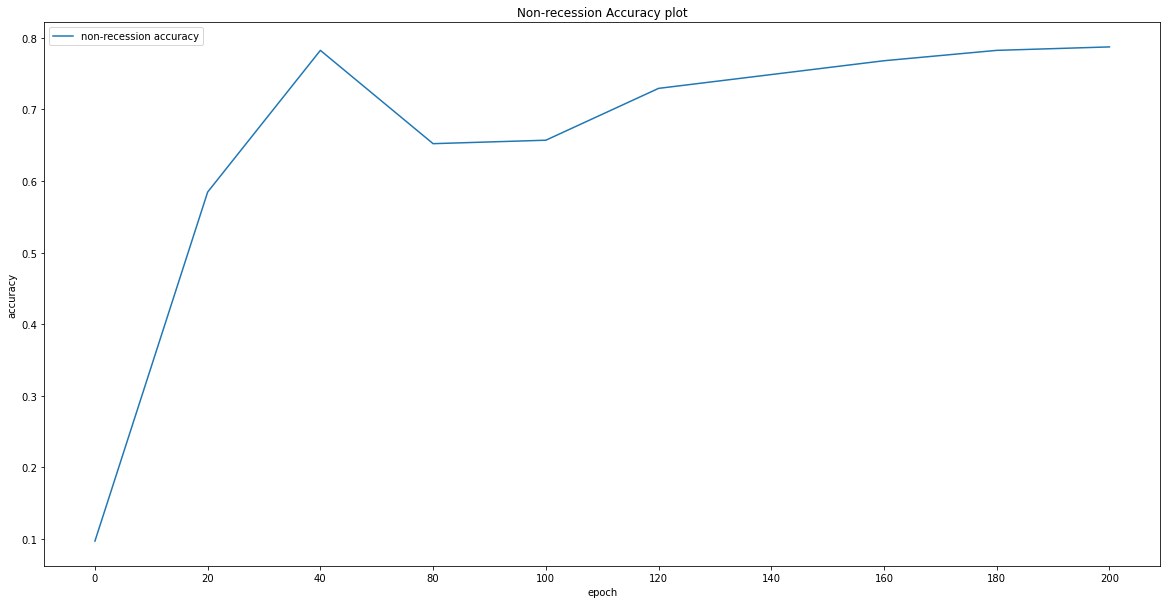

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

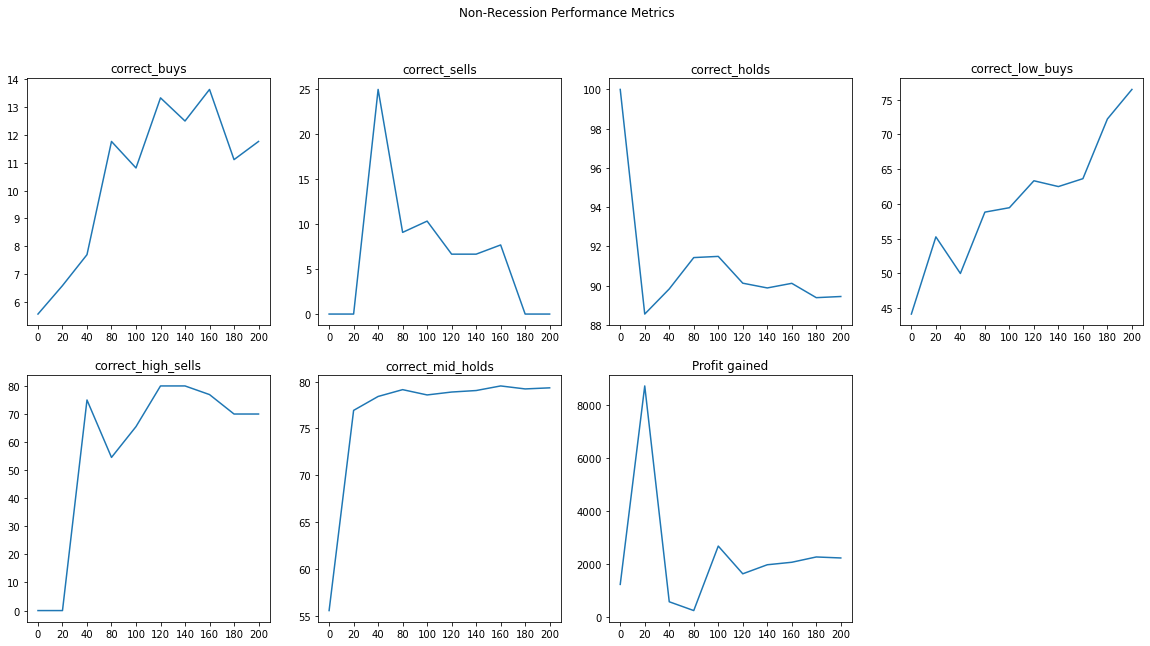

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

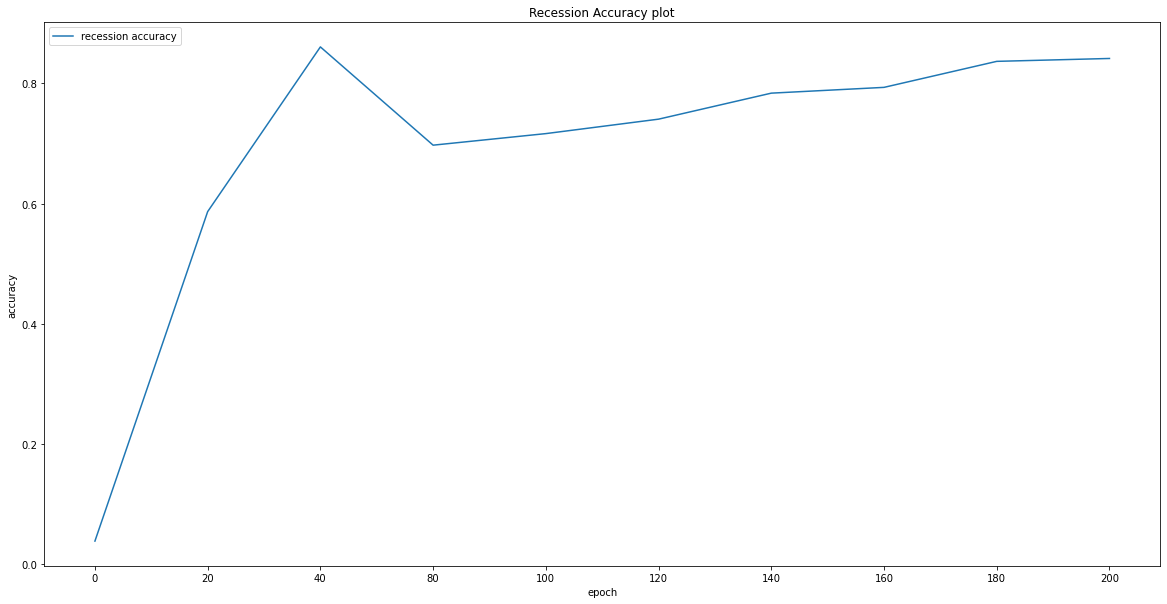

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

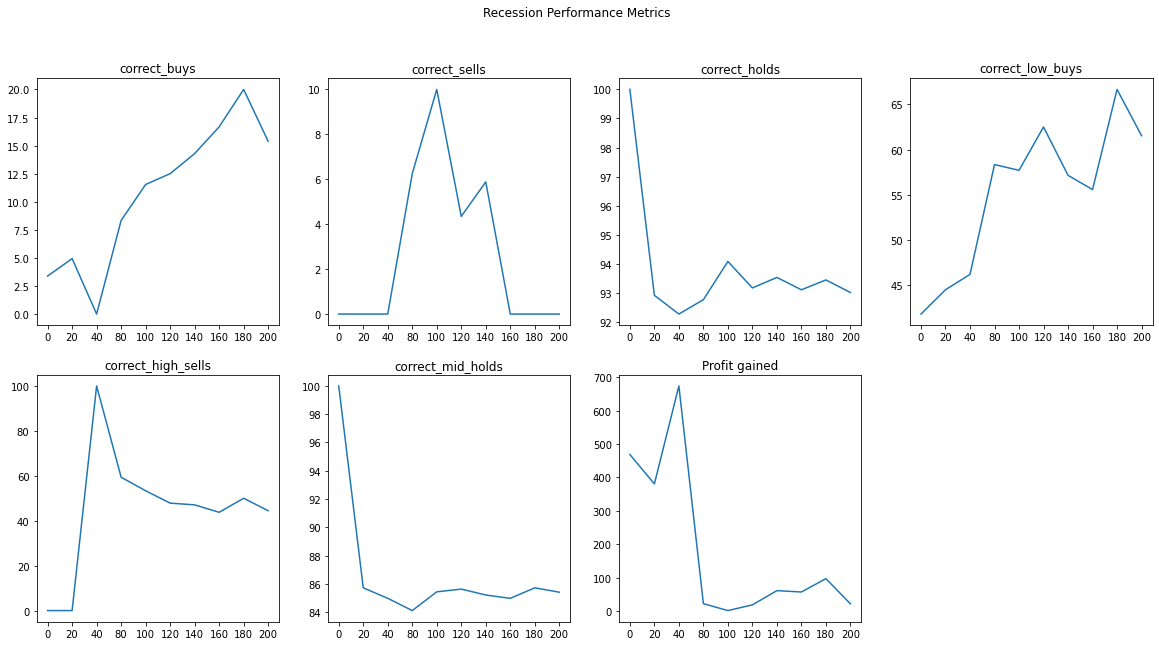

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [35]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-02-05    94.769997  95.729495 -73.397490  42546200.0     2.0
2019-02-06    95.599998  95.709573 -60.096174  48646100.0     2.0
2019-02-07    95.639999  95.698869 -59.455134  52911000.0     2.0
2019-02-08    96.730003  95.857505 -41.987116  59921100.0     2.0
2019-02-11    95.580002  95.814812 -60.416634  53751900.0     2.0


In [36]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-02-05   115.269997  115.577902 -41.666781 -15247800.0     2.0
2020-02-06   116.809998  115.767455  -6.982095  -9564900.0     2.0
2020-02-07   116.309998  115.850923 -20.219894 -14917800.0     2.0
2020-02-10   116.449997  115.943088 -17.142986 -11228200.0     2.0
2020-02-11   115.250000  115.836459 -43.516528 -17373100.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


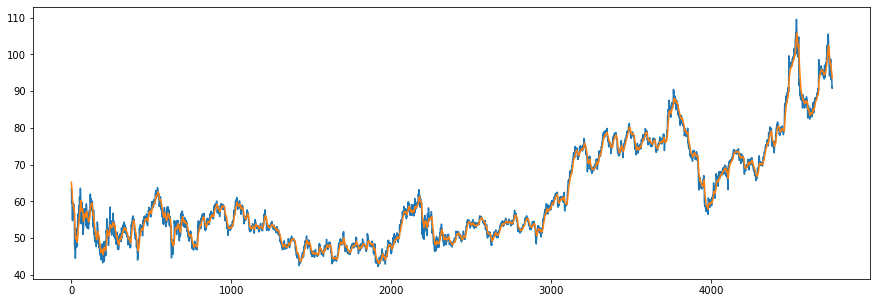

In [37]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 5, 4)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.123595505617978, 1: 7.329479768786127, 2: 0.3672169128294237}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2700 - accuracy: 0.4537 - mse: 0.4596 - weighted_accuracy: 0.4073 - weighted_mse: 0.4865 - val_loss: 0.3002 - val_accuracy: 0.0452 - val_mse: 0.3465 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3465
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1983 - accuracy: 0.2942 - mse: 0.7863 - weighted_accuracy: 0.5485 - weighted_mse: 0.7349 - val_loss: 0.2903 - val_accuracy: 0.0452 - val_mse: 0.3666 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3666
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1772 - accuracy: 0.2463 - mse: 1.0630 - weighted_accuracy: 0.5686 - weighted_mse: 0.9886 - val_loss: 0.2767 - val_accuracy: 0.0452 - val_mse: 0.3913 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3913
Epoch 4/20
30/30 [==============================] - 0s 7m

7/7 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.4521 - mse: 1.2103 - weighted_accuracy: 0.4521 - weighted_mse: 1.2103
Test loss: 0.1716776043176651
Test accuracy: 0.45205479860305786


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 49
actual holds but predicted sell: 64
actual predicted holds: 88
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 93.61702127659575%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.18181818181818%
Percentage high sells correct: 51.42857142857143%
Percentage mid holds correct: 86.02150537634408%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price 

30/30 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.4348 - mse: 1.7611 - weighted_accuracy: 0.7222 - weighted_mse: 1.7288 - val_loss: 0.1923 - val_accuracy: 0.3691 - val_mse: 1.7922 - val_weighted_accuracy: 0.3691 - val_weighted_mse: 1.7922
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1313 - accuracy: 0.4430 - mse: 1.7909 - weighted_accuracy: 0.7306 - weighted_mse: 1.7553 - val_loss: 0.1966 - val_accuracy: 0.3607 - val_mse: 1.8094 - val_weighted_accuracy: 0.3607 - val_weighted_mse: 1.8094
Epoch 12/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1314 - accuracy: 0.4364 - mse: 1.8056 - weighted_accuracy: 0.7212 - weighted_mse: 1.7537 - val_loss: 0.1914 - val_accuracy: 0.3722 - val_mse: 1.8511 - val_weighted_accuracy: 0.3722 - val_weighted_mse: 1.8511
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1298 - accuracy: 0.4572 - mse: 1.8158 - weighted_accuracy: 0.7412 - weighted_mse: 1.7716

7/7 [==============================] - 0s 3ms/step - loss: 0.1835 - accuracy: 0.4292 - mse: 1.9211 - weighted_accuracy: 0.4292 - weighted_mse: 1.9211
Test loss: 0.1835240125656128
Test accuracy: 0.4292237460613251


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 50
actual holds but predicted sell: 69
actual predicted holds: 82
Percentage buys correct: 5.660377358490566%
Percentage sells correct: 11.39240506329114%
Percentage holds correct: 94.25287356321839%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.056603773584904%
Percentage high sells correct: 53.164556962025316%
Percentage mid holds correct: 86.04651162790698%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price

30/30 [==============================] - 0s 7ms/step - loss: 0.1183 - accuracy: 0.5287 - mse: 2.0149 - weighted_accuracy: 0.7892 - weighted_mse: 1.9737 - val_loss: 0.1954 - val_accuracy: 0.3975 - val_mse: 2.1186 - val_weighted_accuracy: 0.3975 - val_weighted_mse: 2.1186
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.5289 - mse: 2.0528 - weighted_accuracy: 0.7857 - weighted_mse: 2.0335 - val_loss: 0.1722 - val_accuracy: 0.5152 - val_mse: 2.1271 - val_weighted_accuracy: 0.5152 - val_weighted_mse: 2.1271
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1161 - accuracy: 0.5386 - mse: 2.0396 - weighted_accuracy: 0.7910 - weighted_mse: 2.0177 - val_loss: 0.1891 - val_accuracy: 0.4374 - val_mse: 2.1745 - val_weighted_accuracy: 0.4374 - val_weighted_mse: 2.1745
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1156 - accuracy: 0.5457 - mse: 2.0815 - weighted_accuracy: 0.7844 - weighted_mse: 2.0555 

7/7 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.5114 - mse: 2.3044 - weighted_accuracy: 0.5114 - weighted_mse: 2.3044
Test loss: 0.17194953560829163
Test accuracy: 0.5114155411720276


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 43
actual holds but predicted sell: 54
actual predicted holds: 104
Percentage buys correct: 4.444444444444445%
Percentage sells correct: 10.0%
Percentage holds correct: 91.2280701754386%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 83.1858407079646%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fro

30/30 [==============================] - 0s 6ms/step - loss: 0.1025 - accuracy: 0.6096 - mse: 2.3994 - weighted_accuracy: 0.8369 - weighted_mse: 2.3402 - val_loss: 0.1922 - val_accuracy: 0.4732 - val_mse: 2.6252 - val_weighted_accuracy: 0.4732 - val_weighted_mse: 2.6252
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1016 - accuracy: 0.6146 - mse: 2.4692 - weighted_accuracy: 0.8280 - weighted_mse: 2.4442 - val_loss: 0.1711 - val_accuracy: 0.5478 - val_mse: 2.7320 - val_weighted_accuracy: 0.5478 - val_weighted_mse: 2.7320
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1006 - accuracy: 0.6293 - mse: 2.4533 - weighted_accuracy: 0.8333 - weighted_mse: 2.4244 - val_loss: 0.1874 - val_accuracy: 0.4848 - val_mse: 2.6942 - val_weighted_accuracy: 0.4848 - val_weighted_mse: 2.6942
Epoch 11/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1006 - accuracy: 0.6335 - mse: 2.5053 - weighted_accuracy: 0.8258 - weighted_mse: 2.4618 

7/7 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.5616 - mse: 2.8366 - weighted_accuracy: 0.5616 - weighted_mse: 2.8366
Test loss: 0.15826387703418732
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 41
actual holds but predicted sell: 45
actual predicted holds: 115
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 92.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 50.98039215686274%
Percentage mid holds correct: 83.06451612903226%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fr

30/30 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.6943 - mse: 3.0329 - weighted_accuracy: 0.8625 - weighted_mse: 2.9609 - val_loss: 0.1850 - val_accuracy: 0.5510 - val_mse: 3.2401 - val_weighted_accuracy: 0.5510 - val_weighted_mse: 3.2401
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.6979 - mse: 3.1016 - weighted_accuracy: 0.8658 - weighted_mse: 3.0072 - val_loss: 0.1832 - val_accuracy: 0.5584 - val_mse: 3.2541 - val_weighted_accuracy: 0.5584 - val_weighted_mse: 3.2541
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.6966 - mse: 3.0903 - weighted_accuracy: 0.8672 - weighted_mse: 2.9723 - val_loss: 0.1675 - val_accuracy: 0.6015 - val_mse: 3.3105 - val_weighted_accuracy: 0.6015 - val_weighted_mse: 3.3105
Epoch 13/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0855 - accuracy: 0.6914 - mse: 3.1481 - weighted_accuracy: 0.8687 - weighted_mse: 3.0350

Share price: $0.36904808178762694
Shares owned at the moment: 701
Cash capital at the moment: $0.3641988498892488


Price increase from previously bought: 9.42810530822642%
Share price: $0.40495288996638945
Shares owned at the moment: 0
Cash capital at the moment: $283.45552678269553


Share price: $0.39756674547558357
Shares owned at the moment: 711
Cash capital at the moment: $0.008228370464507861


Price increase from previously bought: 2.196051412956357%
Share price: $0.4074148337749641
Shares owned at the moment: 0
Cash capital at the moment: $288.88357733072553


Share price: $0.42608540916354065
Shares owned at the moment: 676
Cash capital at the moment: $0.057747960537028575


Price increase from previously bought: -2.0510115863089373%
Share price: $0.41849405051117317
Shares owned at the moment: 0
Cash capital at the moment: $282.18174566618984


Share price: $0.41808377872059066
Shares owned at the moment: 673
Cash capital at the moment: $0.03759403376517412


Price increase 

30/30 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.7660 - mse: 4.0160 - weighted_accuracy: 0.8962 - weighted_mse: 3.7447 - val_loss: 0.1975 - val_accuracy: 0.5804 - val_mse: 4.1298 - val_weighted_accuracy: 0.5804 - val_weighted_mse: 4.1298
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0726 - accuracy: 0.7603 - mse: 3.9965 - weighted_accuracy: 0.8867 - weighted_mse: 3.7203 - val_loss: 0.1798 - val_accuracy: 0.6278 - val_mse: 4.3573 - val_weighted_accuracy: 0.6278 - val_weighted_mse: 4.3573
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0702 - accuracy: 0.7603 - mse: 4.0974 - weighted_accuracy: 0.8958 - weighted_mse: 3.8190 - val_loss: 0.1898 - val_accuracy: 0.6078 - val_mse: 4.0085 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 4.0085
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.7560 - mse: 4.1657 - weighted_accuracy: 0.8890 - weighted_mse: 3.8864

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.7660 - mse: 4.2548 - weighted_accuracy: 0.9051 - weighted_mse: 3.9144 - val_loss: 0.1832 - val_accuracy: 0.6341 - val_mse: 4.3802 - val_weighted_accuracy: 0.6341 - val_weighted_mse: 4.3802
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.7763 - mse: 4.1948 - weighted_accuracy: 0.9052 - weighted_mse: 3.9023 - val_loss: 0.2029 - val_accuracy: 0.6057 - val_mse: 4.5576 - val_weighted_accuracy: 0.6057 - val_weighted_mse: 4.5576
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.7553 - mse: 4.3245 - weighted_accuracy: 0.8958 - weighted_mse: 4.0004 - val_loss: 0.1827 - val_accuracy: 0.6404 - val_mse: 4.1178 - val_weighted_accuracy: 0.6404 - val_weighted_mse: 4.1178
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.7813 - mse: 4.3295 - weighted_accuracy: 0.9035 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1353 - accuracy: 0.7763 - mse: 5.1871 - weighted_accuracy: 0.7763 - weighted_mse: 5.1871
Test loss: 0.1352766901254654
Test accuracy: 0.77625572681427


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 17
actual holds but predicted sell: 21
actual predicted holds: 163
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 19.23076923076923%
Percentage holds correct: 93.67816091954023%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.70520231213872%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from 

30/30 [==============================] - 0s 7ms/step - loss: 0.0534 - accuracy: 0.8462 - mse: 6.0028 - weighted_accuracy: 0.9364 - weighted_mse: 5.2411 - val_loss: 0.2017 - val_accuracy: 0.6898 - val_mse: 5.8355 - val_weighted_accuracy: 0.6898 - val_weighted_mse: 5.8355
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0538 - accuracy: 0.8394 - mse: 5.9911 - weighted_accuracy: 0.9338 - weighted_mse: 5.2064 - val_loss: 0.1891 - val_accuracy: 0.7287 - val_mse: 6.6542 - val_weighted_accuracy: 0.7287 - val_weighted_mse: 6.6542
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.8378 - mse: 6.1191 - weighted_accuracy: 0.9314 - weighted_mse: 5.3293 - val_loss: 0.1985 - val_accuracy: 0.6972 - val_mse: 6.0939 - val_weighted_accuracy: 0.6972 - val_weighted_mse: 6.0939
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0561 - accuracy: 0.8265 - mse: 6.1822 - weighted_accuracy: 0.9220 - weighted_mse: 5.4294

0         255.731682  



RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.8452 - mse: 6.2448 - weighted_accuracy: 0.9431 - weighted_mse: 5.3485 - val_loss: 0.1934 - val_accuracy: 0.7119 - val_mse: 6.2697 - val_weighted_accuracy: 0.7119 - val_weighted_mse: 6.2697
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0513 - accuracy: 0.8488 - mse: 6.1654 - weighted_accuracy: 0.9372 - weighted_mse: 5.3507 - val_loss: 0.2192 - val_accuracy: 0.6698 - val_mse: 6.8090 - val_weighted_accuracy: 0.6698 - val_weighted_mse: 6.8090
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.8341 - mse: 6.3698 - weighted_accuracy: 0.9338 - weighted_mse: 5.5294 - val_loss: 0.1895 - val_accuracy: 0.7382 - val_mse: 6.7503 - val_weighted_accuracy: 0.7382 - val_weighted_mse: 6.7503
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0511 - accuracy: 0.8557 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.7945 - mse: 7.6416 - weighted_accuracy: 0.7945 - weighted_mse: 7.6416
Test loss: 0.14143811166286469
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 20
actual predicted holds: 169
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 92.85714285714286%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 39.130434782608695%
Percentage mid holds correct: 85.6353591160221%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Pr

30/30 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.8901 - mse: 8.5752 - weighted_accuracy: 0.9543 - weighted_mse: 6.9783 - val_loss: 0.2193 - val_accuracy: 0.7676 - val_mse: 9.3288 - val_weighted_accuracy: 0.7676 - val_weighted_mse: 9.3288
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.8899 - mse: 8.7831 - weighted_accuracy: 0.9523 - weighted_mse: 7.1696 - val_loss: 0.2219 - val_accuracy: 0.7571 - val_mse: 8.7992 - val_weighted_accuracy: 0.7571 - val_weighted_mse: 8.7992
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.8799 - mse: 8.8650 - weighted_accuracy: 0.9505 - weighted_mse: 7.2737 - val_loss: 0.2395 - val_accuracy: 0.6982 - val_mse: 8.9403 - val_weighted_accuracy: 0.6982 - val_weighted_mse: 8.9403
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.8793 - mse: 8.7435 - weighted_accuracy: 0.9539 - weighted_mse: 7.1585

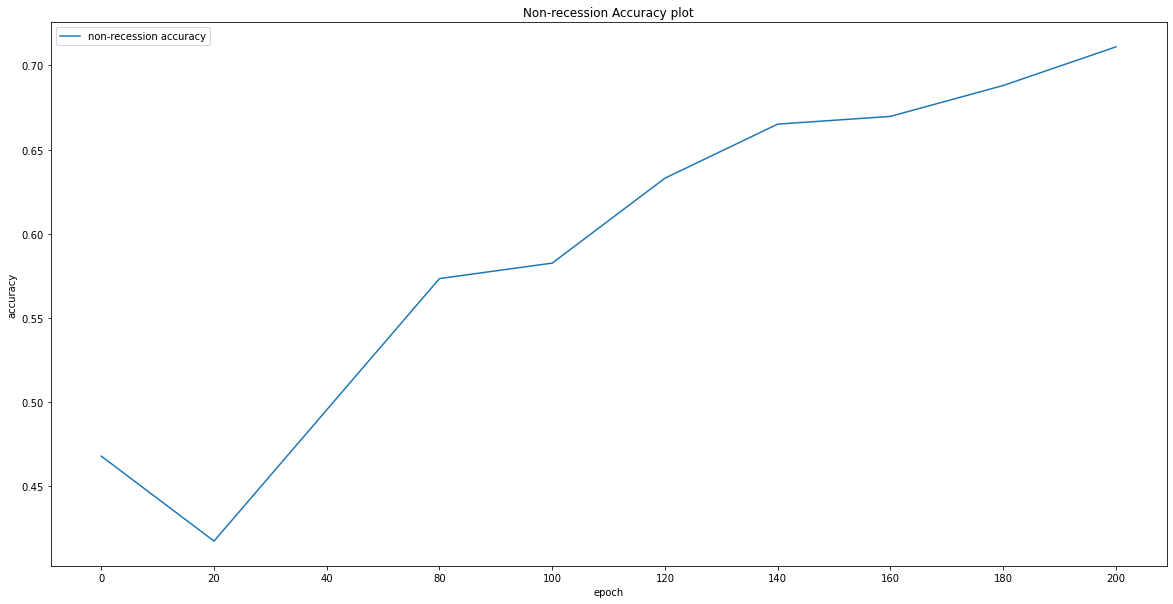

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

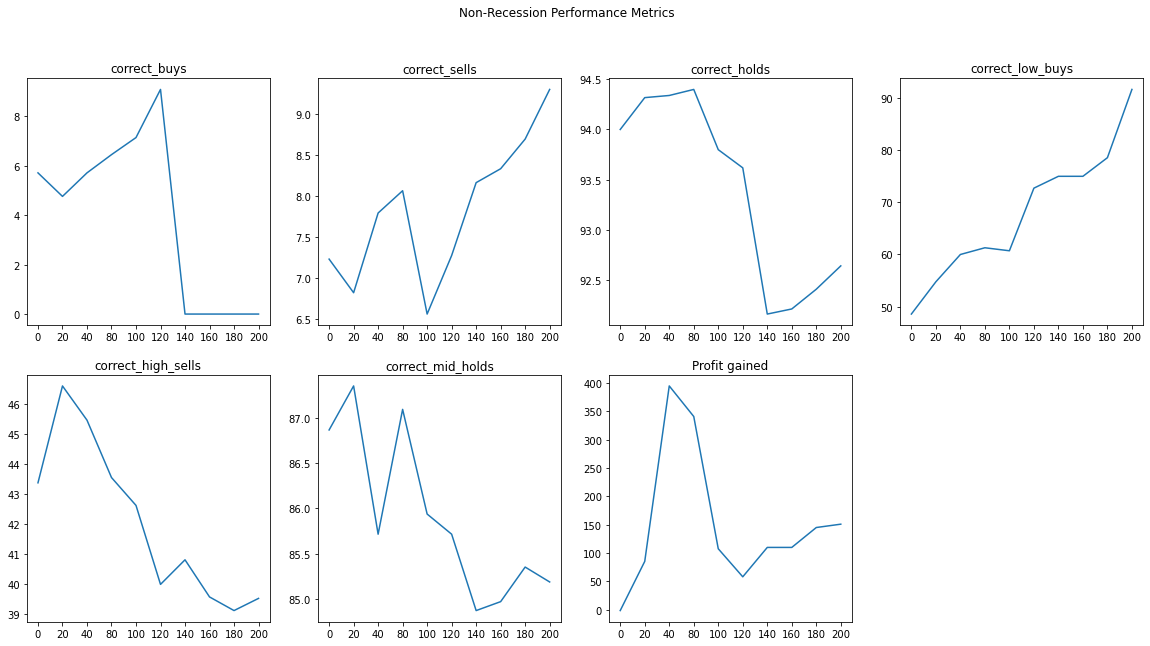

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

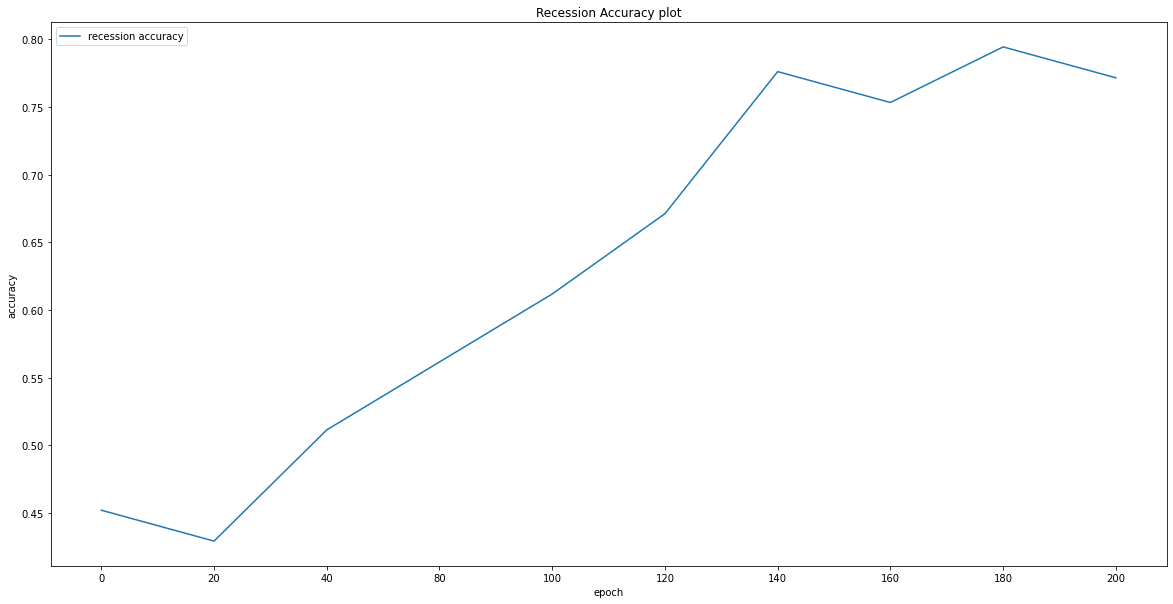

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

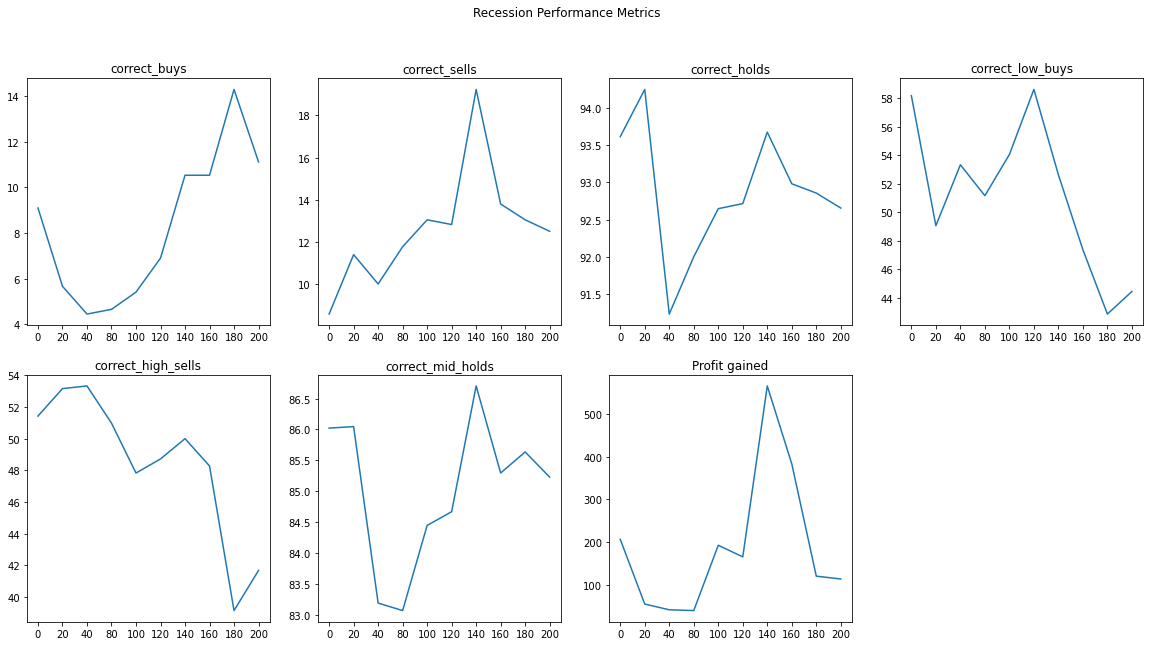

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [47]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-02-05    32.270000  31.221691  -2.583014  2341900.0     2.0
2019-02-06    32.529999  31.422969  -6.451637  2446400.0     2.0
2019-02-07    32.380001  31.570205 -12.698342  2354600.0     2.0
2019-02-08    32.240002  31.673251 -17.589484  2224500.0     2.0
2019-02-11    33.660000  31.978904  -0.753738  2502700.0     2.0


In [48]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name));df = df.iloc[10:]
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_5 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 4:
            data_5.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_5_arr = min_max_scaler.fit_transform(data_5)
            sequential.append(data_5_arr)
            data_5 = data_5[1:5]
        else:
            data_5.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 5, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-02-05    31.209999  32.420759 -94.776143 -266300.0     2.0
2020-02-06    32.360001  32.411412 -66.169143 -148200.0     2.0
2020-02-07    32.389999  32.408118 -65.422905  -37200.0     2.0
2020-02-10    33.000000  32.499176 -47.089930  183100.0     2.0
2020-02-11    33.680000  32.680842 -26.373606  310600.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


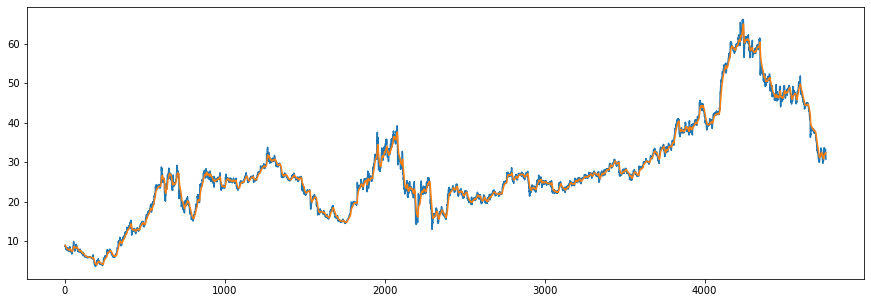

In [49]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 5, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.287356321839081, 1: 7.163841807909605, 2: 0.3672169128294237}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 0.2705 - accuracy: 0.4624 - mse: 0.4635 - weighted_accuracy: 0.3948 - weighted_mse: 0.4972 - val_loss: 0.3001 - val_accuracy: 0.0463 - val_mse: 0.3466 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3466
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2035 - accuracy: 0.2915 - mse: 0.7880 - weighted_accuracy: 0.5054 - weighted_mse: 0.7584 - val_loss: 0.2905 - val_accuracy: 0.0463 - val_mse: 0.3675 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3675
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1833 - accuracy: 0.2655 - mse: 1.0413 - weighted_accuracy: 0.5336 - weighted_mse: 0.9990 - val_loss: 0.2776 - val_accuracy: 0.0463 - val_mse: 0.3934 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3934
Epoch 4/20
30/30 [==============================] - 0s 7m

7/7 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.5845 - mse: 1.1923 - weighted_accuracy: 0.5845 - weighted_mse: 1.1923
Test loss: 0.16963370144367218
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 24
actual holds but predicted sell: 54
actual predicted holds: 121
Percentage buys correct: 4.0%
Percentage sells correct: 10.0%
Percentage holds correct: 90.29850746268657%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.166666666666664%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 82.08955223880596%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: 0.237

Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.4493 - mse: 1.6458 - weighted_accuracy: 0.7039 - weighted_mse: 1.5714 - val_loss: 0.1777 - val_accuracy: 0.4458 - val_mse: 1.6708 - val_weighted_accuracy: 0.4458 - val_weighted_mse: 1.6708
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.4955 - mse: 1.6368 - weighted_accuracy: 0.7245 - weighted_mse: 1.5742 - val_loss: 0.1791 - val_accuracy: 0.4564 - val_mse: 1.6495 - val_weighted_accuracy: 0.4564 - val_weighted_mse: 1.6495
Epoch 17/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1338 - accuracy: 0.4642 - mse: 1.6548 - weighted_accuracy: 0.7203 - weighted_mse: 1.5787 - val_loss: 0.1710 - val_accuracy: 0.4826 - val_mse: 1.7030 - val_weighted_accuracy: 0.4826 - val_weighted_mse: 1.7030
Epoch 18/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1318 - accuracy: 0.4761 - mse: 1.6811 - weighted_accuracy: 0.7282 - weighted

0         -65.971313  



RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1295 - accuracy: 0.5068 - mse: 1.6981 - weighted_accuracy: 0.7360 - weighted_mse: 1.6265 - val_loss: 0.1725 - val_accuracy: 0.4932 - val_mse: 1.6004 - val_weighted_accuracy: 0.4932 - val_weighted_mse: 1.6004
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.4932 - mse: 1.7034 - weighted_accuracy: 0.7310 - weighted_mse: 1.6356 - val_loss: 0.1759 - val_accuracy: 0.4616 - val_mse: 1.7277 - val_weighted_accuracy: 0.4616 - val_weighted_mse: 1.7277
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.4903 - mse: 1.7297 - weighted_accuracy: 0.7316 - weighted_mse: 1.6600 - val_loss: 0.1789 - val_accuracy: 0.4416 - val_mse: 1.7113 - val_weighted_accuracy: 0.4416 - val_weighted_mse: 1.7113
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.5181 - ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.5068 - mse: 1.9710 - weighted_accuracy: 0.5068 - weighted_mse: 1.9710
Test loss: 0.1852177381515503
Test accuracy: 0.5068492889404297


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 32
actual holds but predicted sell: 66
actual predicted holds: 101
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 91.81818181818181%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 60.0%
Percentage high sells correct: 54.794520547945204%
Percentage mid holds correct: 83.63636363636364%


Capital: 100
Share price: $0.543669029946819
Shares owned at the moment: 183
Cash capital at the moment: $0.23496608041138245


Price increase from

Epoch 9/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1054 - accuracy: 0.6293 - mse: 2.0613 - weighted_accuracy: 0.8206 - weighted_mse: 1.9937 - val_loss: 0.1643 - val_accuracy: 0.5668 - val_mse: 2.0909 - val_weighted_accuracy: 0.5668 - val_weighted_mse: 2.0909
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1049 - accuracy: 0.6406 - mse: 2.0436 - weighted_accuracy: 0.8267 - weighted_mse: 1.9692 - val_loss: 0.1566 - val_accuracy: 0.6141 - val_mse: 2.1135 - val_weighted_accuracy: 0.6141 - val_weighted_mse: 2.1135
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.6435 - mse: 2.0695 - weighted_accuracy: 0.8258 - weighted_mse: 2.0014 - val_loss: 0.1895 - val_accuracy: 0.4711 - val_mse: 2.1872 - val_weighted_accuracy: 0.4711 - val_weighted_mse: 2.1872
Epoch 12/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1048 - accuracy: 0.6356 - mse: 2.0947 - weighted_accuracy: 0.8266 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.5479 - mse: 2.3051 - weighted_accuracy: 0.5479 - weighted_mse: 2.3051
Test loss: 0.1877557933330536
Test accuracy: 0.5479452013969421


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 31
actual holds but predicted sell: 55
actual predicted holds: 113
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.4%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 83.2%


Capital: 100
Share price: $0.543669029946819
Shares owned at the moment: 183
Cash capital at the moment: $0.23496608041138245


Price increase from previously 

Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0894 - accuracy: 0.7093 - mse: 2.4253 - weighted_accuracy: 0.8770 - weighted_mse: 2.3289 - val_loss: 0.1806 - val_accuracy: 0.5426 - val_mse: 2.5561 - val_weighted_accuracy: 0.5426 - val_weighted_mse: 2.5561
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0899 - accuracy: 0.7137 - mse: 2.4663 - weighted_accuracy: 0.8678 - weighted_mse: 2.3656 - val_loss: 0.1483 - val_accuracy: 0.6488 - val_mse: 2.4958 - val_weighted_accuracy: 0.6488 - val_weighted_mse: 2.4958
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0883 - accuracy: 0.7203 - mse: 2.4518 - weighted_accuracy: 0.8757 - weighted_mse: 2.3648 - val_loss: 0.1823 - val_accuracy: 0.5594 - val_mse: 2.6055 - val_weighted_accuracy: 0.5594 - val_weighted_mse: 2.6055
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.7161 - mse: 2.4904 - weighted_accuracy: 0.8814 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1801 - accuracy: 0.6164 - mse: 2.6898 - weighted_accuracy: 0.6164 - weighted_mse: 2.6898
Test loss: 0.1800539493560791
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 24
actual holds but predicted sell: 47
actual predicted holds: 128
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 9.615384615384615%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 84.28571428571429%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Price

Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0755 - accuracy: 0.7713 - mse: 2.9543 - weighted_accuracy: 0.8980 - weighted_mse: 2.8026 - val_loss: 0.1973 - val_accuracy: 0.5573 - val_mse: 3.0911 - val_weighted_accuracy: 0.5573 - val_weighted_mse: 3.0911
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0733 - accuracy: 0.7744 - mse: 2.9836 - weighted_accuracy: 0.9064 - weighted_mse: 2.8318 - val_loss: 0.1526 - val_accuracy: 0.6614 - val_mse: 3.0661 - val_weighted_accuracy: 0.6614 - val_weighted_mse: 3.0661
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0740 - accuracy: 0.7794 - mse: 3.0973 - weighted_accuracy: 0.9063 - weighted_mse: 2.8952 - val_loss: 0.1701 - val_accuracy: 0.6320 - val_mse: 3.1795 - val_weighted_accuracy: 0.6320 - val_weighted_mse: 3.1795
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0719 - accuracy: 0.7873 - mse: 3.0407 - weighted_accuracy: 0.9092 - weighted

Epoch 1/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0692 - accuracy: 0.7978 - mse: 3.2303 - weighted_accuracy: 0.9077 - weighted_mse: 3.0024 - val_loss: 0.1529 - val_accuracy: 0.6719 - val_mse: 3.3783 - val_weighted_accuracy: 0.6719 - val_weighted_mse: 3.3783
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.8015 - mse: 3.2280 - weighted_accuracy: 0.9127 - weighted_mse: 3.0446 - val_loss: 0.1535 - val_accuracy: 0.6730 - val_mse: 3.3724 - val_weighted_accuracy: 0.6730 - val_weighted_mse: 3.3724
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.7928 - mse: 3.2545 - weighted_accuracy: 0.9077 - weighted_mse: 3.0527 - val_loss: 0.1451 - val_accuracy: 0.7108 - val_mse: 3.3628 - val_weighted_accuracy: 0.7108 - val_weighted_mse: 3.3628
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0678 - accuracy: 0.8021 - mse: 3.2936 - weighted_accuracy: 0.9219 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.2039 - accuracy: 0.6758 - mse: 3.9972 - weighted_accuracy: 0.6758 - weighted_mse: 3.9972
Test loss: 0.20386432111263275
Test accuracy: 0.6757990717887878


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 15
actual holds but predicted sell: 43
actual predicted holds: 141
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 92.15686274509804%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 72.22222222222223%
Percentage high sells correct: 59.57446808510638%
Percentage mid holds correct: 83.66013071895425%


Capital: 100
Share price: $0.543669029946819
Shares owned at the moment: 183
Cash capital at the moment: $0.23496608041138245


Pric

Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.8596 - mse: 4.5817 - weighted_accuracy: 0.9448 - weighted_mse: 4.0440 - val_loss: 0.1691 - val_accuracy: 0.7056 - val_mse: 4.5788 - val_weighted_accuracy: 0.7056 - val_weighted_mse: 4.5788
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.8628 - mse: 4.5115 - weighted_accuracy: 0.9460 - weighted_mse: 4.0136 - val_loss: 0.1689 - val_accuracy: 0.6972 - val_mse: 4.5404 - val_weighted_accuracy: 0.6972 - val_weighted_mse: 4.5404
Epoch 17/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.8659 - mse: 4.5369 - weighted_accuracy: 0.9490 - weighted_mse: 4.0108 - val_loss: 0.1480 - val_accuracy: 0.7508 - val_mse: 4.7069 - val_weighted_accuracy: 0.7508 - val_weighted_mse: 4.7069
Epoch 18/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0492 - accuracy: 0.8651 - mse: 4.6542 - weighted_accuracy: 0.9451 - weighted




RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0486 - accuracy: 0.8654 - mse: 4.8302 - weighted_accuracy: 0.9469 - weighted_mse: 4.2464 - val_loss: 0.1494 - val_accuracy: 0.7603 - val_mse: 5.0134 - val_weighted_accuracy: 0.7603 - val_weighted_mse: 5.0134
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.8688 - mse: 4.7983 - weighted_accuracy: 0.9464 - weighted_mse: 4.2585 - val_loss: 0.1519 - val_accuracy: 0.7613 - val_mse: 5.1522 - val_weighted_accuracy: 0.7613 - val_weighted_mse: 5.1522
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.8628 - mse: 4.8365 - weighted_accuracy: 0.9442 - weighted_mse: 4.2942 - val_loss: 0.1547 - val_accuracy: 0.7592 - val_mse: 5.0769 - val_weighted_accuracy: 0.7592 - val_weighted_mse: 5.0769
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.8746 - mse: 4.9146 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2170 - accuracy: 0.7078 - mse: 5.4207 - weighted_accuracy: 0.7078 - weighted_mse: 5.4207
Test loss: 0.21702057123184204
Test accuracy: 0.7077625393867493


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 13
actual holds but predicted sell: 35
actual predicted holds: 151
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 90.96385542168674%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 60.526315789473685%
Percentage mid holds correct: 83.03030303030303%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Pri

Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9046 - mse: 6.6305 - weighted_accuracy: 0.9650 - weighted_mse: 5.5260 - val_loss: 0.1843 - val_accuracy: 0.7424 - val_mse: 6.3852 - val_weighted_accuracy: 0.7424 - val_weighted_mse: 6.3852
Epoch 16/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9109 - mse: 6.5152 - weighted_accuracy: 0.9655 - weighted_mse: 5.4698 - val_loss: 0.1778 - val_accuracy: 0.7371 - val_mse: 6.5648 - val_weighted_accuracy: 0.7371 - val_weighted_mse: 6.5648
Epoch 17/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9161 - mse: 6.5909 - weighted_accuracy: 0.9692 - weighted_mse: 5.4903 - val_loss: 0.1630 - val_accuracy: 0.7781 - val_mse: 6.7882 - val_weighted_accuracy: 0.7781 - val_weighted_mse: 6.7882
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9172 - mse: 6.7842 - weighted_accuracy: 0.9696 - weighted

0         -65.971313  


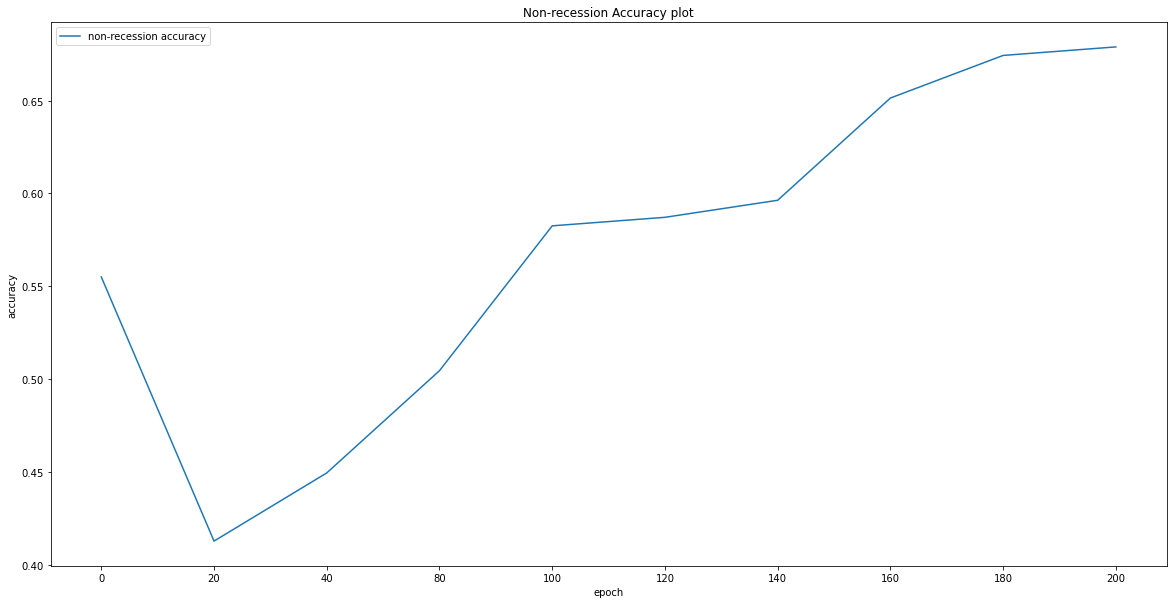

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

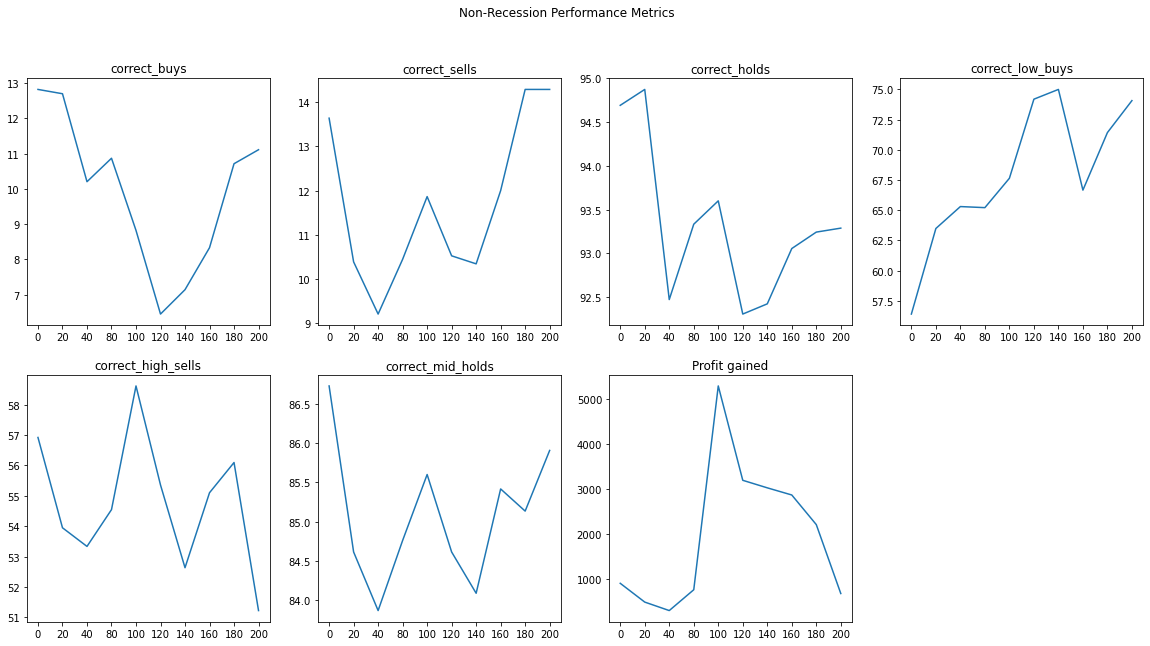

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

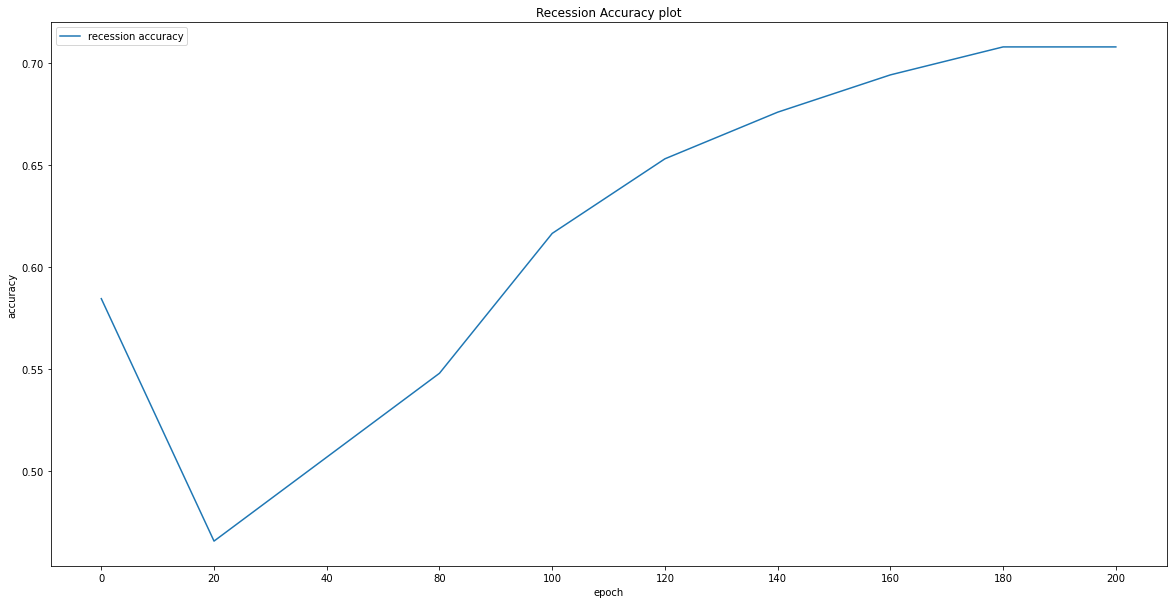

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

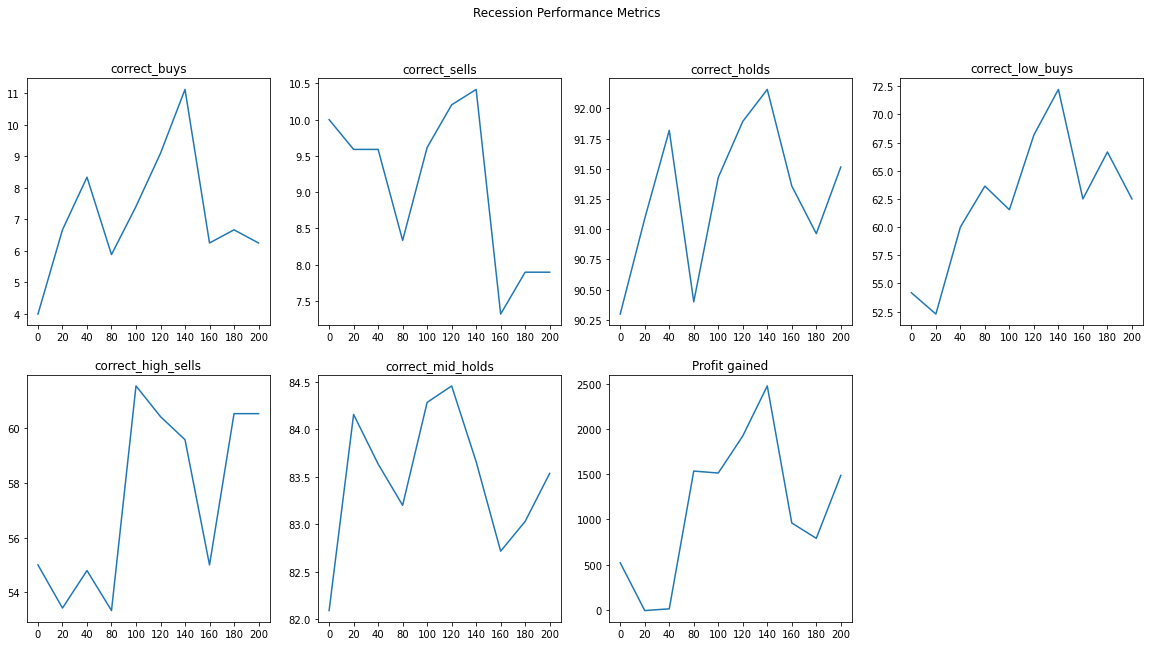

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")